In [1]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/LSTM FX Trading/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/LSTM FX Trading


In [3]:
import plotly.express as px
import numpy as np
import pandas as pd
import requests
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
import json
from datetime import datetime, timedelta, timezone
from tqdm import trange
import pickle

warnings.filterwarnings("ignore")

In [4]:
X_train = np.load('X_train.npz')['arr_0']
y_train = np.load('y_train.npz')['arr_0']
X_test = np.load('X_test.npz')['arr_0']
y_test = np.load('y_test.npz')['arr_0']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(133668, 60, 39) (89113, 60, 39) (133668,) (89113,)


In [5]:
# try changing to a logistic regression
y_train = (y_train > 0.5)
y_test = (y_test > 0.5)

In [6]:
# Check proportions
print(y_train.mean(), y_test.mean())

0.3323682556782476 0.3252050767003692


In [7]:
# Train LSTM
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History, EarlyStopping
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
np.random.seed(10)

# Reshape's last 2 values

# 1. Input Layer
lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name='lstm_input')

# 2. LSTM Layer
inputs = LSTM(150, name='first_layer')(lstm_input)

# # 3. First layer - 64 nodes dense layer
# inputs = Dense(128, name='dense_layer_1')(inputs)
# inputs = Dropout(0.50)(inputs)
# inputs = Activation('relu', name='activation_layer_1')(inputs)

# 4. Second layer - 32 nodes dense layer
inputs = Dense(64, name='dense_layer_2')(inputs)
inputs = Dropout(0.50)(inputs)
inputs = Activation('relu', name='activation_layer_2')(inputs)

# 3. Third layer - 16 nodes dense layer
inputs = Dense(32, name='dense_layer_3')(inputs)
inputs = Dropout(0.50)(inputs)
inputs = Activation('relu', name='activation_layer_3')(inputs)

# 5. Output layer
inputs = Dense(1, name='last_layer')(inputs)
# output = Activation('linear', name='output')(inputs)
output = Activation('sigmoid', name='output')(inputs)

# Build model
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
# model.compile(optimizer=adam, loss='mse')
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['AUC'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 60, 39)]          0         
                                                                 
 first_layer (LSTM)          (None, 150)               114000    
                                                                 
 dense_layer_2 (Dense)       (None, 64)                9664      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 activation_layer_2 (Activat  (None, 64)               0         
 ion)                                                            
                                                                 
 dense_layer_3 (Dense)       (None, 32)                2080      
                                                             

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=15, 
    # epochs = 2,
    shuffle=False, 
    # validation_split = 0.1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
  )

Epoch 1/15
4178/4178 [==============================] - 43s 10ms/step - loss: 0.6279 - auc: 0.5839 - val_loss: 0.6650 - val_auc: 0.5191
Epoch 2/15
4178/4178 [==============================] - 38s 9ms/step - loss: 0.6055 - auc: 0.6539 - val_loss: 0.6411 - val_auc: 0.5371
Epoch 3/15
4178/4178 [==============================] - 51s 12ms/step - loss: 0.6010 - auc: 0.6585 - val_loss: 0.6256 - val_auc: 0.5978
Epoch 4/15
4178/4178 [==============================] - 38s 9ms/step - loss: 0.5987 - auc: 0.6600 - val_loss: 0.6295 - val_auc: 0.6020
Epoch 5/15
4178/4178 [==============================] - 36s 9ms/step - loss: 0.5971 - auc: 0.6610 - val_loss: 0.6370 - val_auc: 0.5429
Epoch 6/15
4178/4178 [==============================] - 37s 9ms/step - loss: 0.5963 - auc: 0.6621 - val_loss: 0.6395 - val_auc: 0.5590
Epoch 7/15
4178/4178 [==============================] - 45s 11ms/step - loss: 0.5951 - auc: 0.6637 - val_loss: 0.6364 - val_auc: 0.5810


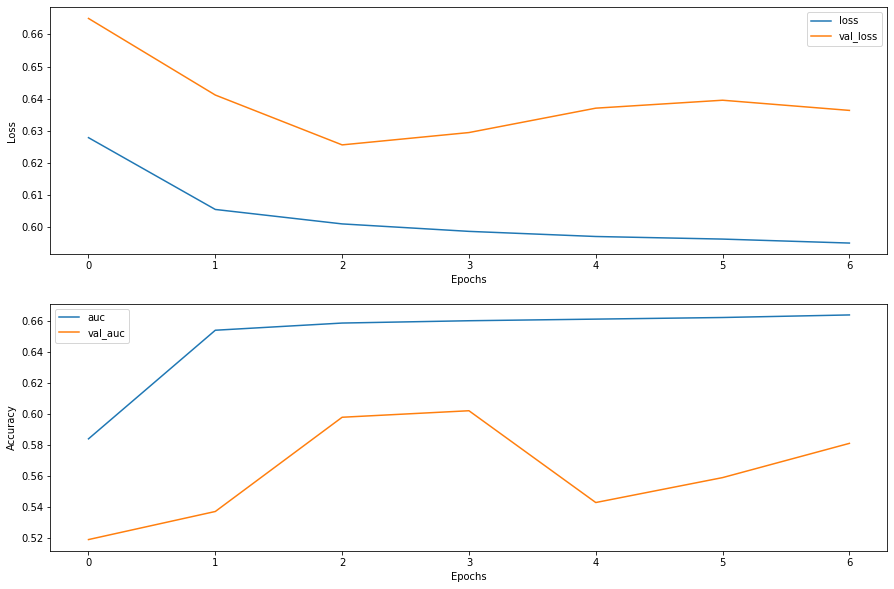

In [9]:
# Plot train vs val (loss & acc)
f, ax = plt.subplots(nrows=2, figsize=(15,10))
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['auc'], label='auc')
ax[1].plot(history.history['val_auc'], label='val_auc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [12]:
y_pred = model.predict(X_test)
print(X_test.shape, y_pred.shape)

2785/2785 [==============================] - 9s 3ms/step
(89113, 60, 39) (89113, 1)


In [13]:
y_pred.reshape(-1,1)

array([[0.1904692 ],
       [0.27928767],
       [0.44408804],
       ...,
       [0.4243353 ],
       [0.42223653],
       [0.41577706]], dtype=float32)

In [14]:
y_pred.mean()

0.40101063

In [11]:
pickle.dump(model, open('LSTM.pkl', 'wb'))
loaded_model = pickle.load(open('LSTM.pkl', 'rb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......auc
.........vars
............0
............1
............2
............3
......mean
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-22 16:53:12         4453
variables.h5                                   2023-03-22 16:53:12       541960
metadata.json                               

In [15]:
price_df = pd.read_csv('GBP_JPY.csv')

In [16]:
ending_idx_frm_bk = 300
starting_idx_frm_bk =  ending_idx_frm_bk + 12 * 24 * 5 * 12 # 8 weeks

0.4328106659650802 0.379514681994915
0.4328106659650802 0.379514681994915
-750.1029999999955 0 346


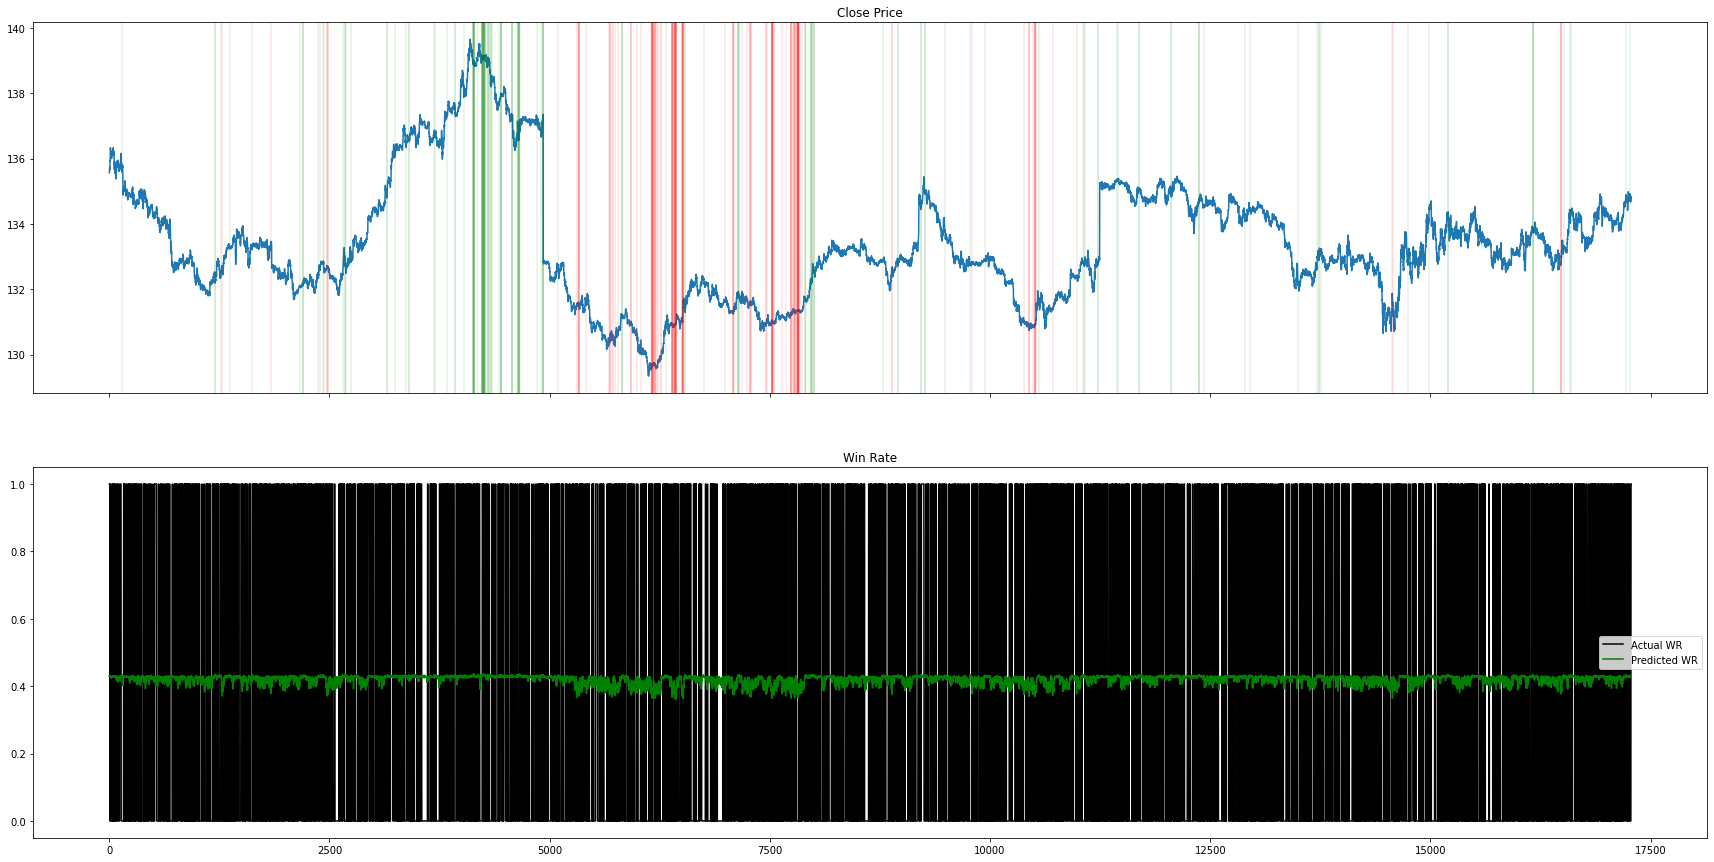

In [17]:
x_df = pd.DataFrame(
    {
        'close' : np.array(np.array(price_df.tail(starting_idx_frm_bk)[:(starting_idx_frm_bk - ending_idx_frm_bk)]['close'])),
        'predicted_wr': y_pred.reshape(-1,)[-starting_idx_frm_bk:-ending_idx_frm_bk]
    }
)

buy_signal = x_df['predicted_wr'].quantile(0.99)
sell_signal = x_df['predicted_wr'].quantile(0.01)

print(buy_signal, sell_signal)

# manual buy & sell signal
# buy_signal = 0.75
# sell_signal = 0.35
print(buy_signal, sell_signal)

x_df['buy'] = x_df['predicted_wr'] > buy_signal
x_df['sell'] = x_df['predicted_wr'] < sell_signal

x_df['buy_cost'] = np.where(x_df['buy'] == True, x_df['close'], 0)
x_df['sell_profits'] = np.where(x_df['sell'] == True, x_df['close'], 0)

# Calculate profits assuming cash out all at the end
buy_ct = x_df['buy'].sum()
sell_ct = x_df['sell'].sum()
balance = buy_ct - sell_ct
balance_value = balance * x_df.iloc[-1,:]['close']

profits = x_df['sell_profits'].sum() - x_df['buy_cost'].sum() + balance_value

trades_taken = buy_ct + sell_ct

print(profits, balance, trades_taken)

# Plot graph
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(30, 15))
ax[0].plot(np.array(price_df.tail(starting_idx_frm_bk)[:(starting_idx_frm_bk - ending_idx_frm_bk)]['close']))

min_y = price_df.tail(starting_idx_frm_bk)[:(starting_idx_frm_bk - ending_idx_frm_bk)]['close'].min()
max_y = price_df.tail(starting_idx_frm_bk)[:(starting_idx_frm_bk - ending_idx_frm_bk)]['close'].max()

# Plot buy lines
for idx in list(x_df[x_df['buy']]['buy'].index):
  ax[0].axvline(x=idx, color = 'green', alpha = 0.1)

# Plot sell lines
for idx in list(x_df[x_df['sell']]['sell'].index):
  ax[0].axvline(x=idx, color = 'red', alpha = 0.1)

ax[1].plot(y_test.reshape(-1,)[-starting_idx_frm_bk:-ending_idx_frm_bk], color = 'black', label = 'Actual WR')
ax[1].plot(y_pred.reshape(-1,)[-starting_idx_frm_bk:-ending_idx_frm_bk], color = 'green', label = 'Predicted WR')
ax[0].set_title('Close Price')
ax[1].set_title('Win Rate')
ax[1].legend()
plt.show()

In [ ]:
x_df[x_df['buy']]['buy'].index